# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

### **Notebook 2 - Modeling and Predictions**
* **Important Note**: Runt the EDA notebook before

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [71]:
# Add the base path to sys.path
BASE_DIR = Path().resolve().parent
sys.path.append(str(BASE_DIR / 'core'))

from core.flight_analysis_utils import *
#from core.classes.Multicollinearity import Multicollinearity

# Define the path to load the file
file_path = os.path.join("..", "data", "df_merged.csv")

# Load the DataFrame
df_merged = pd.read_csv(file_path)
print("DataFrame loaded successfully")

DataFrame loaded successfully


### **1. Correlation Analysis**
Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in your data.
* **Correlation Matrix** and **Heatmap**

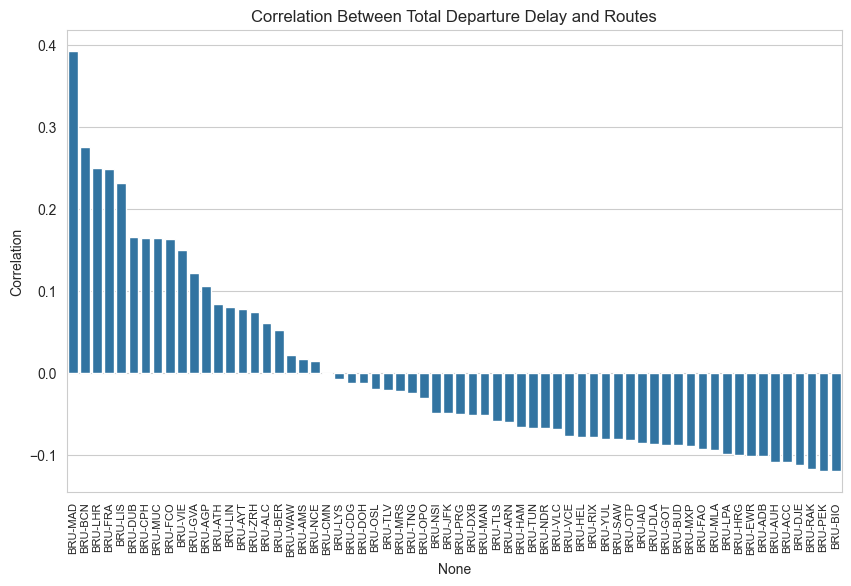

Routes showing the strongest positive correlation with Departure Delays:

BRU-MAD    0.392701
BRU-BCN    0.275766
BRU-LHR    0.250346
BRU-FRA    0.248473
BRU-LIS    0.231481
Name: total_dep_delay_15, dtype: float64


In [72]:
try:
    # One-hot encode the 'route_iata_code' column
    df_encoded = pd.get_dummies(df_merged, columns=['route_iata_code'], drop_first=False, prefix='')
    
    # Convert the dummy variables to a numerical format (e.g., 2 for 1, 1 for 0)
    for col in df_encoded.columns:
        if '-' in col:
            df_encoded[col] = df_encoded[col] * 2  # Change 0 to 0, 1 to 2
    
    # Remove leading underscores from the column names
    df_encoded.columns = df_encoded.columns.str.lstrip('_')
    
    # Select the route code columns and the 'total_dep_delay' column
    route_columns = [col for col in df_encoded.columns if '-' in col]
    corr_columns = ['total_dep_delay_15'] + route_columns
except KeyError as e:
    print(f"Encoding error: {e}")

# Create a subset of the dataframe for correlation
corr_df = df_encoded[corr_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# Extract only the correlation of 'total_dep_delay' with the routes
total_dep_delay_corr = correlation_matrix['total_dep_delay_15'][route_columns].sort_values(ascending=False)

# Filter for only positive correlations
positive_corr = total_dep_delay_corr[total_dep_delay_corr > 0.2]

# Plot the correlation between total_dep_delay and the route codes
plt.figure(figsize=(10, 6))
sns.barplot(x=total_dep_delay_corr.index, y=total_dep_delay_corr.values)
plt.xticks(rotation=90, fontsize=8)
plt.title('Correlation Between Total Departure Delay and Routes', fontsize=12)
plt.ylabel('Correlation')
plt.show()

# Print correlation values for better inspection
print('Routes showing the strongest positive correlation with Departure Delays:\n')
print(positive_corr)

* **Positive correlation with delays**: More likely to experience delays. A high positive correlation indicates that delays are more frequent on that route.
* **Negative correlation with delays**: Less likely to be delayed. These routes tend to run on time, indicating more consistent operational conditions or favorable factors.

C:\Testing\Anaconda\envs\DTCS\lib\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


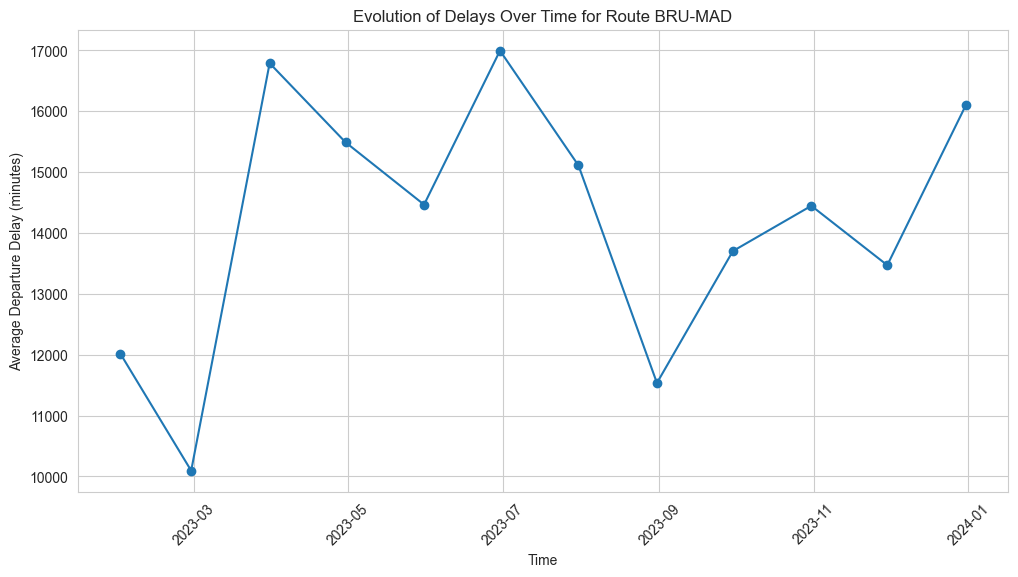

In [73]:
# Filter the dataframe for the specific route you want to analyze
route_code = 'BRU-MAD'  # Replace with the specific route code
df_route = df_merged[df_merged['route_iata_code'] == route_code]
df_route = df_route.infer_objects()

# Convert the 'Month' column to datetime if it's not already
df_route.loc[:, 'Month'] = pd.to_datetime(df_route['Month'])

# Resample the data to a monthly frequency, averaging only the numeric columns (e.g., dep_delay)
df_route_monthly = df_route.resample('ME', on='Month').mean(numeric_only=True)

# Plot the delay over time
plt.figure(figsize=(12, 6))
plt.plot(df_route_monthly.index, df_route_monthly['total_dep_delay'], marker='o', linestyle='-')
plt.title(f'Evolution of Delays Over Time for Route {route_code}')
plt.xlabel('Time')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
#plt.ylim(0, 10000)
plt.show()

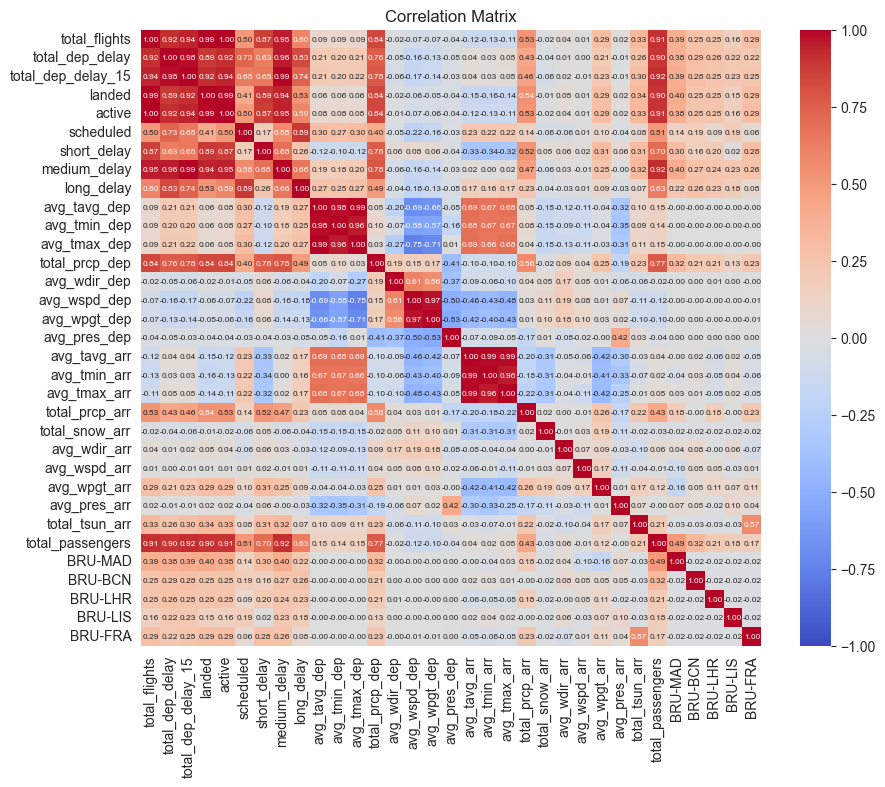

In [74]:
# Select the relevant columns for correlation analysis
corr_columns = ['total_flights', 'total_dep_delay', 'total_dep_delay_15', 'landed', 'active', 'scheduled', 'short_delay', 'medium_delay', 'long_delay', 'avg_tavg_dep', 'avg_tmin_dep', 'avg_tmax_dep', 'total_prcp_dep', 'total_snow_dep', 'avg_wdir_dep', 'avg_wspd_dep', 'avg_wpgt_dep', 'avg_pres_dep', 'total_tsun_dep', 'avg_tavg_arr', 'avg_tmin_arr', 'avg_tmax_arr', 'total_prcp_arr', 'total_snow_arr', 'avg_wdir_arr', 'avg_wspd_arr', 'avg_wpgt_arr', 'avg_pres_arr', 'total_tsun_arr', 'total_passengers', 'BRU-MAD', 'BRU-BCN', 'BRU-LHR', 'BRU-LIS', 'BRU-FRA']

corr_df = df_encoded[corr_columns].dropna() # Drop any rows with NaN values
corr_df = corr_df.loc[:, (corr_df[corr_columns] != 0).any(axis=0)].dropna()
correlation_matrix = corr_df.corr() # Perform the correlation analysis

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 6}) 
plt.title('Correlation Matrix')
plt.show()

* The target variable should be kept in the DataFrame after the VIF process but excluded from the calculations when identifying features with high multicollinearity since the target variable is needed for the modeling stage.

In [75]:
df_encoded.head()

,Month,total_flights,total_dep_delay,total_dep_delay_15,landed,active,scheduled,departures,arrivals,short_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,2023-01,42,1529.0,36,18,21,3,21,21,6,...,0,0,0,0,0,0,0,0,0,0
1,2023-02,35,1206.0,25,14,19,2,19,16,10,...,0,0,0,0,0,0,0,0,0,0
2,2023-03,46,1544.0,37,17,22,7,22,24,9,...,0,0,0,0,0,0,0,0,0,0
3,2023-04,37,1380.0,32,15,18,4,18,19,5,...,0,0,0,0,0,0,0,0,0,0
4,2023-05,39,1624.0,37,17,18,2,18,21,2,...,0,0,0,0,0,0,0,0,0,0


In [76]:
df_encoded['total_passengers'] = pd.to_numeric(df_encoded['total_passengers'], errors='coerce') # Convert 'total_passengers' to numeric, forcing errors to NaN
numeric_df = df_encoded.select_dtypes(include=['number'])
features_to_drop = ['total_flights', 'total_dep_delay_15', 'departures', 'arrivals']
df_reduced = numeric_df.drop(columns=features_to_drop)

# Drop columns with all values as zero
df_reduced = df_reduced.loc[:, (df_reduced != 0).any(axis=0)]
"""
multicollinearity = Multicollinearity(df_reduced)
target_variable = 'total_dep_delay'
df_vif = multicollinearity.remove_high_vif_features(target_variable)
multicollinearity.df = df_vif
final_vif = multicollinearity.calculate_vif() # Display the cleaned DataFrame and final VIF values

print("Final VIF values after feature removal:")
print(final_vif)

correlation_matrix = df_vif.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()"""

'\nmulticollinearity = Multicollinearity(df_reduced)\ntarget_variable = \'total_dep_delay\'\ndf_vif = multicollinearity.remove_high_vif_features(target_variable)\nmulticollinearity.df = df_vif\nfinal_vif = multicollinearity.calculate_vif() # Display the cleaned DataFrame and final VIF values\n\nprint("Final VIF values after feature removal:")\nprint(final_vif)\n\ncorrelation_matrix = df_vif.corr()\n\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', square=True)\nplt.title(\'Correlation Matrix\')\nplt.show()'

### **2. Linear Regression (Scatter Plot)**
First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones, such as Random Forest.

Mean Absolute Error (Test): 235.21
Mean Squared Error (Test): 115821.72
R² Score (Test): 0.99
Mean Squared Error (Cross-Validation): 141794.93
R^2 Score (Cross-Validation): 0.98


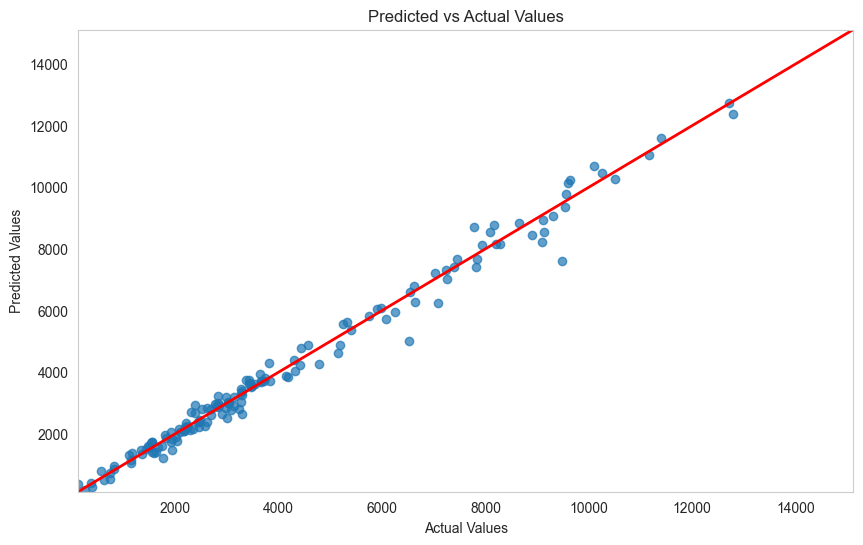

In [77]:
# Split the data into features (X) and target (y)
X = df_reduced.drop(columns=['total_dep_delay'])  # drop the target variable
y = df_reduced['total_dep_delay']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression() # Create a linear regression model
model.fit(X_train, y_train) # Fit the model on the training data
y_pred = model.predict(X_test) # Predict on the test data
test_mae = mean_absolute_error(y_test, y_pred) # Calculate other metrics
test_mse = mean_squared_error(y_test, y_pred) # Evaluate the model
test_r2 = r2_score(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
mean_mse = -np.mean(cv_scores)  # Convert from negative MSE to positive MSE
mean_r2 = np.mean(cross_val_score(model, X, y, cv=5, scoring='r2'))  # Get average r^2 score

print(f'Mean Absolute Error (Test): {test_mae:.2f}')
print(f'Mean Squared Error (Test): {test_mse:.2f}')
print(f'R² Score (Test): {test_r2:.2f}')
print(f'Mean Squared Error (Cross-Validation): {mean_mse:.2f}')
print(f'R^2 Score (Cross-Validation): {mean_r2:.2f}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Diagonal line
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()

Interpretation
**Mean Squared Error (MSE)**: It measures the average squared difference between predicted and actual values.
* A lower MSE indicates a better fit.
* MSE is 102837, so the RMSE would be √103,916= 322 minutes (which is around 5 hours).
**R² Score**: It shows the proportion to which independent variables explain variance in the dependent variable.
* The values range from 0 to 1, where values closer to 1 indicate a better fit.
* 0.99 means that 99% of the variability in the target variable is explained by the model. This suggests a strong model fit, with relatively low unexplained variability.
* The average total departure delay (your target variable) ranges from 0 to 14,000 minutes, an **MAE** of 213.78 may represent approximately 1.5% of the total range, which could be acceptable depending on the context.
* The cross-validation MSE values indicate that the model’s predictions are close to the actual values. The difference between the cross-validation and test set MSE suggests the model generalizes well and doesn’t overfit.

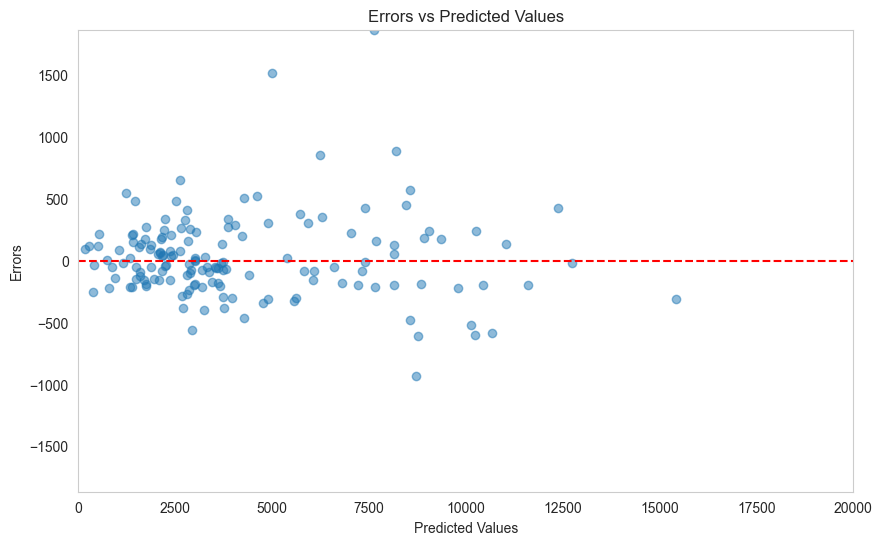

In [78]:
y_true = y_test
residuals = y_true - y_pred # Continue with residual analysis

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Add a line at zero
plt.title('Errors vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Errors')
plt.xlim(0, 20000)
plt.ylim(-max(abs(residuals)), max(abs(residuals)))
plt.grid()
plt.show()

### **3. Checking & Removing Outliers (Box Plot & Histogram)**
* Boxplot of the current model to **find outliers**
* **Remove** them (values above 12000)
* **Log transformation** to reduce skewness and make the distribution more normal
* Box plot to visualize any **remaining outliers**
* **Histogram** to visualize current the distribution
* Check the **model without outliers**

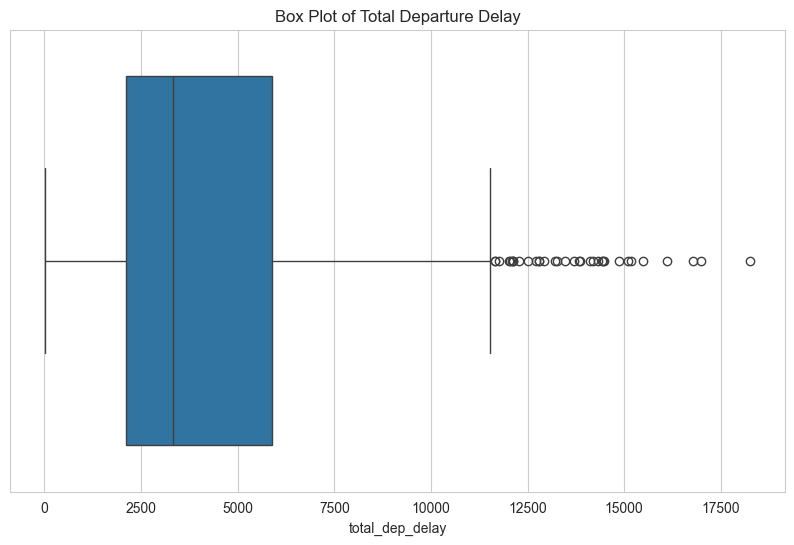

In [79]:
# Box plot to identify outliers in the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_reduced['total_dep_delay'])  # Replace with your target variable
plt.title('Box Plot of Total Departure Delay')
plt.show()

* The solid line in the box indicates the **median**
* The dashed line shows the **mean**
* Points that are further away from the max are considered **extreme values** (outliers)

Q1 and Q3 values show that 50% of the data lies within 3500 min. (from just under 2500 to around 6000), indicating that most flights have relatively small delays.

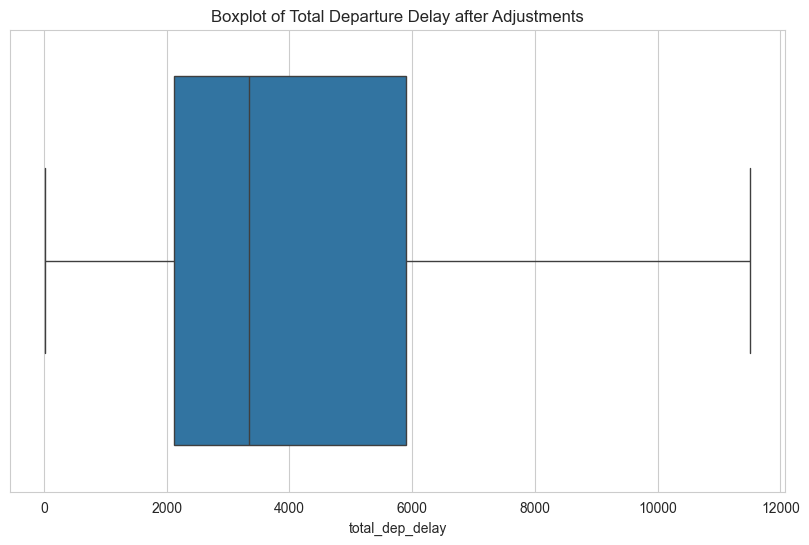

In [80]:
df_after_adj = df_reduced.copy() # Copy of the dataframe to avoid warning

df_after_adj['total_dep_delay'] = df_after_adj['total_dep_delay'].clip(upper=11500) # Cap the outliers at 12000
df_after_adj['log_total_dep_delay'] = np.log1p(df_after_adj['total_dep_delay']) # Log transformation of the total departure delay

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_after_adj['total_dep_delay'])
plt.title('Boxplot of Total Departure Delay after Adjustments')
plt.show()

**Log transformation (Y=log(X))** is used to stabilize variance, reduce skewness, and make data more normally distributed. By transforming the data, we might find that the relationship between variables becomes linear, allowing for more straightforward modeling techniques.

When used with a variable (e.g., the target variable with the delay times), the range of **values are compressed**, mainly the larger ones. The model will predict values in the transformed scale (log scale). To visualize the predictions in their original scale, an exponential function will be used. 
$OriginalPredictions = e^{PredictionsLog}$

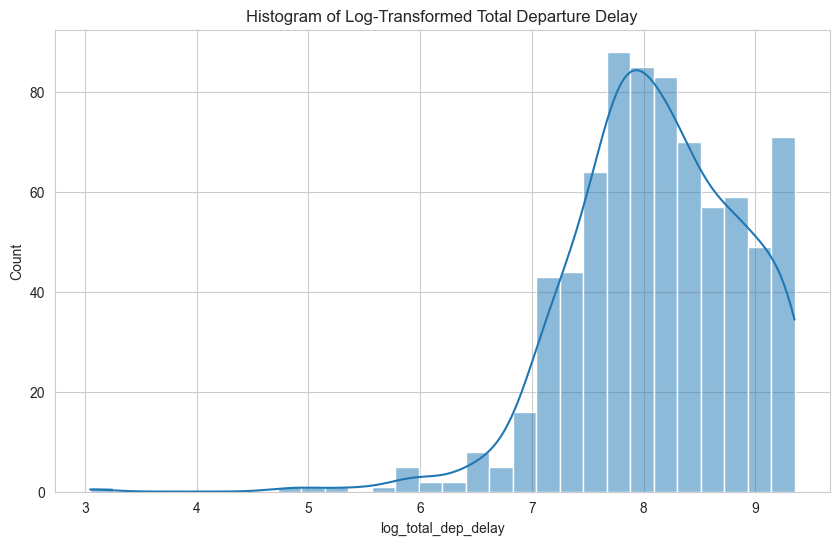

In [81]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_adj['log_total_dep_delay'], bins=30, kde=True)
plt.title('Histogram of Log-Transformed Total Departure Delay')
plt.show()

* Compare the two models (with and without outliers), to compare their performance. **Random Forest** will be used for this.
    * n_estimators=200 (Number of trees in the forest): This parameter specifies the number of trees in the forest. In this case, the model will build 200 decision trees, and the final prediction will be an average of the predictions from all these trees (in a regression task). A higher number of estimators generally improves performance but increases computational cost.
    * random_state=42 (Seed for reproducibility): This parameter sets the seed for the random number generator. Setting a fixed seed like 42 ensures that the random processes within the model (e.g., data sampling for each tree, random feature selection) produce the same results each time the code is run. This helps with reproducibility—if you run the code multiple times, you'll get consistent results.

In [82]:
df_no_outliers = df_after_adj.copy()

X_no_outliers = df_no_outliers.drop(
    columns=['total_dep_delay', 'log_total_dep_delay'])  # Split data into features and target
y_no_outliers = df_no_outliers['log_total_dep_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)  # Train-test split for both datasets
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2,
                                                                random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)  # Fit model with outliers
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse_with_outliers = mean_squared_error(y_test, predictions)  # To evaluate performance
mae_with_outliers = mean_absolute_error(y_test, predictions)
r2_with_outliers = r2_score(y_test, predictions)

model_no_outliers = RandomForestRegressor(n_estimators=200, random_state=42)  # Fit model without outliers
model_no_outliers.fit(X_no_train, y_no_train)
predictions_no_outliers = model_no_outliers.predict(X_no_test)

mse_without_outliers = mean_squared_error(y_no_test, predictions_no_outliers)  # To evaluate performance
mae_without_outliers = mean_absolute_error(y_no_test, predictions_no_outliers)
r2_without_outliers = r2_score(y_no_test, predictions_no_outliers)

print("Results using Random Forest with Outliers:")
print(f'MSE: {mse_with_outliers:.2f}, MAE: {mae_with_outliers:.2f}, R²: {r2_with_outliers:.2f}')
print("Results using Random Forest without Outliers:")
print(f'MSE: {mse_without_outliers:.2f}, MAE: {mae_without_outliers:.2f}, R²: {r2_without_outliers:.2f}')

Results using Random Forest with Outliers:
MSE: 221721.62, MAE: 328.18, R²: 0.98
Results using Random Forest without Outliers:
MSE: 0.02, MAE: 0.10, R²: 0.97


Results
* The MSE and MAE are **much lower without outliers**, indicating that the model is making more accurate predictions.
* The R² score remained the same  **0.98**.

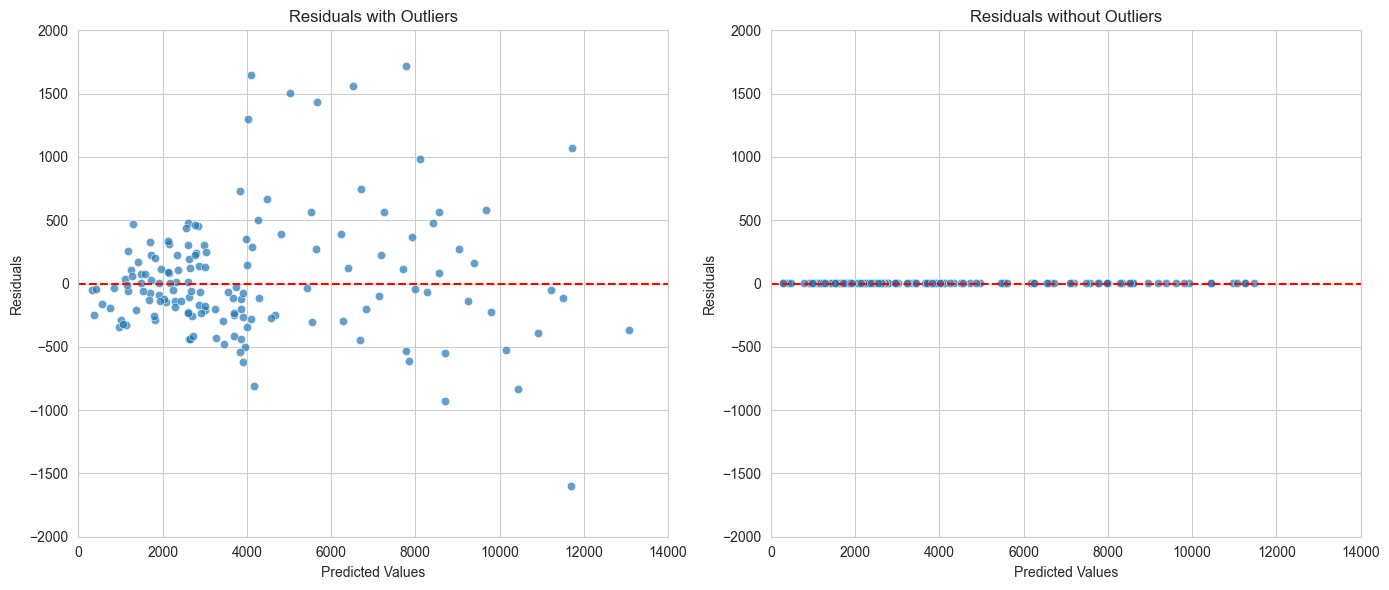

In [83]:
# Calculate residuals for both models
residuals_with_outliers = y_test - predictions
residuals_without_outliers = y_no_test - predictions_no_outliers

# Transform predictions and residuals back to original scale
original_predictions_no_outliers = np.exp(predictions_no_outliers)
original_residuals_without_outliers = np.exp(residuals_without_outliers)

# Residuals for the model with outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=predictions, y=residuals_with_outliers, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-2000,2000)
plt.xlim(0,14000)
plt.title('Residuals with Outliers')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residuals for the model without outliers
plt.subplot(1, 2, 2)
sns.scatterplot(x=original_predictions_no_outliers, y=original_residuals_without_outliers, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-2000,2000)
plt.xlim(0,14000)
plt.title('Residuals without Outliers')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

* Scattered residuals far from the red line mean the model struggles with some parts of the data.
* Tightly clustered residuals around the red line (y = 0) indicate a good model fit.

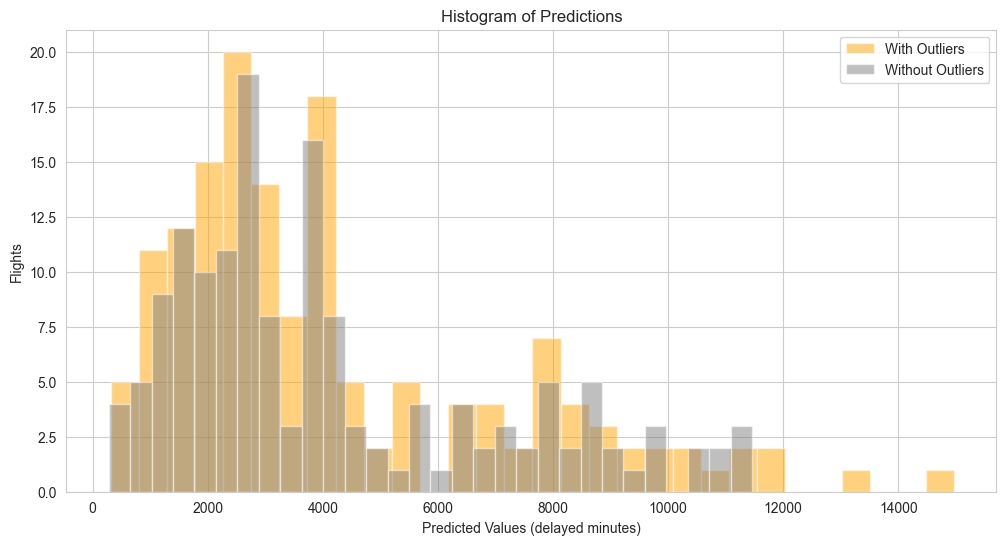

In [84]:
plt.figure(figsize=(12, 6))
plt.hist(predictions, bins=30, alpha=0.5, label='With Outliers', color='orange')
plt.hist(original_predictions_no_outliers, bins=30, alpha=0.5, label='Without Outliers', color='grey')
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Values (delayed minutes)')
plt.ylabel('Flights')
plt.legend()
plt.show()

### **4. Pareto Front**

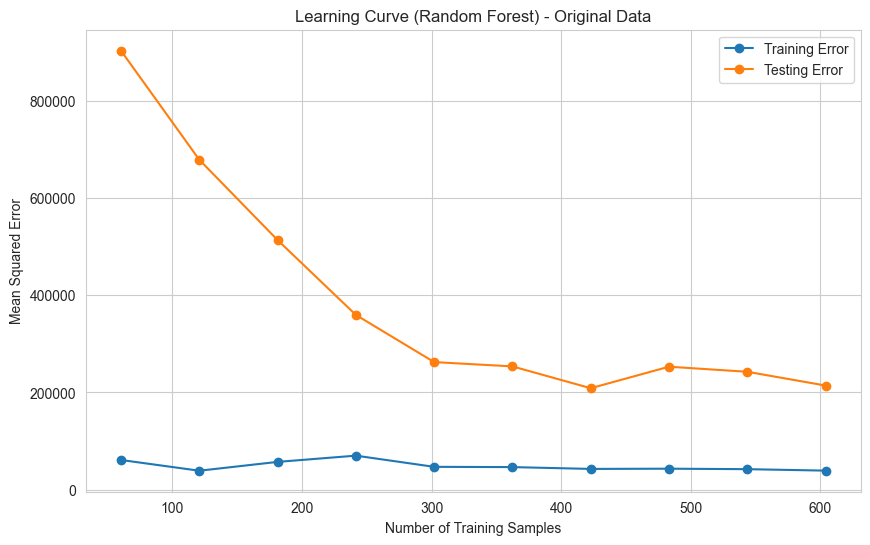

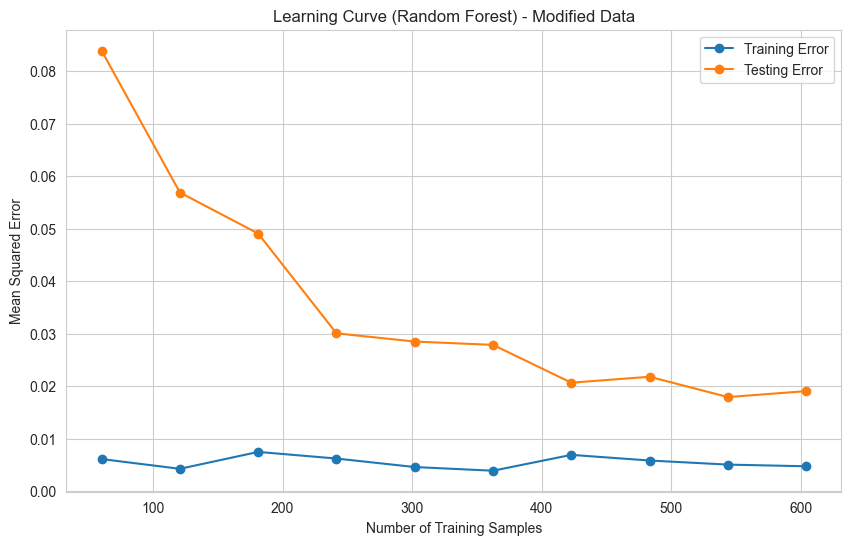

In [85]:
def plot_learning_curve(X_train, X_test, y_train, y_test, dataset_name):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Use 10%, 20%, ..., 100% of the training data
    train_errors = []
    test_errors = []

    # Train the model with increasing data sizes and record the performance
    for train_size in train_sizes:
        # Subset the training data
        X_train_subset = X_train.sample(frac=train_size, random_state=42)
        y_train_subset = y_train.loc[X_train_subset.index]

        # Initialize the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_subset, y_train_subset)
        
        # Calculate performance on the training set
        y_train_pred = model.predict(X_train_subset)
        train_mse = mean_squared_error(y_train_subset, y_train_pred)
        train_errors.append(train_mse)
        
        # Calculate performance on the fixed test set
        y_test_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_errors.append(test_mse)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(X_train), train_errors, label="Training Error", marker='o')
    plt.plot(train_sizes * len(X_train), test_errors, label="Testing Error", marker='o')
    plt.title(f"Learning Curve (Random Forest) - {dataset_name}")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for the first dataset
plot_learning_curve(X_train, X_test, y_train, y_test, "Original Data")

# Plot for the second dataset
plot_learning_curve(X_no_train, X_no_test, y_no_train, y_no_test, "Modified Data")

* **train_sizes**: Defines the proportion of the training set to use, from 10% up to 100%.
* **train_errors and test_errors**: They track the MSE for each subset of the data.
* **Learning Curve Plot**: It shows how the errors change as the model sees more data. If the test error continues to drop, it suggests that more data is beneficial.

Interpretation
* **High initial testing MSE followed by a decrease and plateau**: The model benefits from increased data up to a certain point, beyond which additional samples do not improve performance.
* **Low and constant training MSE**: The model is well-fitted to the training data, but the disparity between training and testing errors raises concerns about potential overfitting.

REGULARIZATION: Reduce overfitting with Lasso (L1)

In [86]:
# Initialize and fit Lasso Regression model
lasso_model = Lasso(alpha=0.01)  # You can tune the alpha parameter
lasso_model.fit(X_train, y_train)

# Predict and calculate MSE
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}, Testing MSE: {test_mse}')


Training MSE: 79757.83560551362, Testing MSE: 117456.0383226856


C:\Testing\Anaconda\envs\DTCS\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.411e+07, tolerance: 6.608e+05
  model = cd_fast.enet_coordinate_descent(


### **5. Randomized and Grid Search**
* RandomForestRegressor
* Hyperparameter Tuning: Helps to identify the best combination of hyperparameters that optimize model performance. 
    * Grid Search CV. Tests all combinations.
    * Randomized Search CV. Tests random samples.

In [88]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}
rf = RandomForestRegressor(random_state=42) # Initialize RandomForestRegressor
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2) # Initialize GridSearchCV
grid_search.fit(X_no_train, y_no_train) # Fit grid search to the training data without outliers
print(f"Best Parameters Grid Search: {grid_search.best_params_}")

grid_best_rf = grid_search.best_estimator_ # Train the model using the best parameters
grid_best_rf.fit(X_no_train, y_no_train)
grid_best_predictions_no_outliers = grid_best_rf.predict(X_no_test) # Predict using the test set (without outliers)

# Evaluate the tuned model performance on the test set (without outliers)
grid_best_mse_without_outliers = mean_squared_error(y_no_test, grid_best_predictions_no_outliers)
grid_best_mae_without_outliers = mean_absolute_error(y_no_test, grid_best_predictions_no_outliers)
grid_best_r2_without_outliers = r2_score(y_no_test, grid_best_predictions_no_outliers)

print("Tuned Grid Model Without Outliers:")
print(f'MSE: {grid_best_mse_without_outliers:.2f}, MAE: {grid_best_mae_without_outliers:.2f}, R²: {grid_best_r2_without_outliers:.2f}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Grid Model Without Outliers:
MSE: 0.02, MAE: 0.10, R²: 0.97


In [89]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_no_train, y_no_train) # Fit grid search to the training data without outliers
print(f"Best Parameters Randomized Search: {random_search.best_params_}")

random_best_rf = random_search.best_estimator_ # Train the model using the best parameters
random_best_rf.fit(X_no_train, y_no_train)
random_best_predictions_no_outliers = random_best_rf.predict(X_no_test) # Predict using the test set (without outliers)

# Evaluate the tuned model performance on the test set (without outliers)
random_best_mse_without_outliers = mean_squared_error(y_no_test, random_best_predictions_no_outliers)
random_best_mae_without_outliers = mean_absolute_error(y_no_test, random_best_predictions_no_outliers)
random_best_r2_without_outliers = r2_score(y_no_test, random_best_predictions_no_outliers)

print("Tuned Randomized Model Without Outliers:")
print(f'MSE: {random_best_mse_without_outliers:.2f}, MAE: {random_best_mae_without_outliers:.2f}, R²: {random_best_r2_without_outliers:.2f}')

Best Parameters Randomized Search: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Tuned Randomized Model Without Outliers:
MSE: 0.04, MAE: 0.14, R²: 0.93


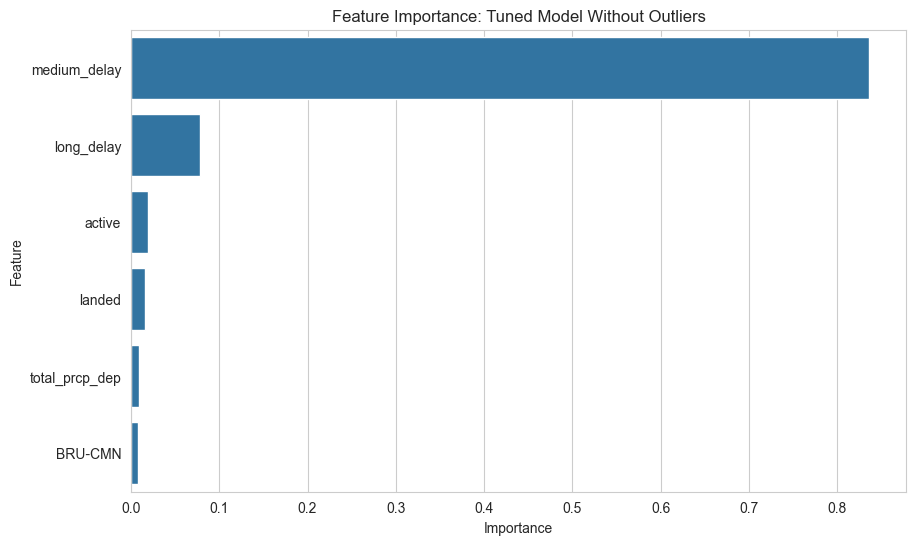

In [90]:
# Calculate feature importances
importances = model_no_outliers.feature_importances_
feature_names = X_no_train.columns

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get the top features
top_importances = importance_df.head(6)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_importances)
plt.title('Feature Importance: Tuned Model Without Outliers')
plt.show()